
### Selection and Backtesting of a Portfolio of Pairs Based on Cointegration in Python
Author: Piotr Arendarski, Ph.D, Anglia Ruskin University
*****
#### A brief outline of what this script does:
1. Select universe of stocks (index), get tickers and download historical data
2. Select pairs based on Engle-Granger cointegration test
3. Backtest portfolio of pairs using zscore method
4. Check current zScore of cointegrated pairs
5. Parameters optimisation

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import itertools
from datetime import datetime, timedelta, date
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from arch.unitroot import engle_granger
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
from bs4 import BeautifulSoup
import requests, requests_html
warnings.simplefilter('ignore')

### Part 1: Selecting universe, getting tickers and downloading historical data

The function to get tickers works only for stooq.com website. Please check what is the symbol of your desired index and check if the index has constituents. Then it is important to select either yahoo or stooq as the source for downloading historical data. This will deteremin the format of tickers. The stooq's tickers have the format of 'XX.US' for US stocks, but for german stocks it is XX.DE, yahoo's tickers have the format of 'XX' for US stocks.
Please take a note that stooq.com and yahoo.finance.com has a limit of requests, so you may see an error due to too many requests if you select index with more than 100 constituents.

In [209]:
# SELECTS PERIOD, INDEX and HISTORICAL DATA SOURCE 
index = '^dji' # or e.g. ^spx, ^dax, ^ndx
data_source = 'yahoo' # select: 'yahoo' or'stooq'
start_date = '2017/01/01'
end_date = date.today() # Please do not change this, otherwise current Z-score are calculated incorrectly

# GETTING TICKERS from stooq.com
def getTickers(index = index, data_source = data_source):
# info about the function: https://github.com/parendarski/getTickers        
    tickers = []
    url = f'https://stooq.pl/q/i/?s={index}&i'
    print(f'Getting tickers from page number: 1')
    data = pd.read_html(url) 
    # clean_table(data)
    data = data[0].iloc[1:]
    new_header = data.iloc[0] #grab the first row for the header
    data = data[3:] #take the data less the header row
    data.columns = new_header #set the header row as the df header

    # iterates through the column with tickers at the FIRST PAGE
    for ticker in data.iloc[:,0]:
        if data_source == 'yahoo':
            if str('nan') not in str(ticker):
                tickers.append(ticker.split('.')[0])
        else:
            if str('nan') not in str(ticker):
                tickers.append(ticker) 
    print(f'Tickers collected so far: {len(tickers)}')
    print('---')
    
    # iterates through the column with tickers for the NEXT PAGES, break the loop when the last page with tickers is found 
    for page in range(2, 100, 1):        
        url = f'https://stooq.pl/q/i/?s={index}&l={page}&i'
        print(f'Getting tickers from page number: {page}')
        data = pd.read_html(url)
        data = data[0].iloc[1:]
        new_header = data.iloc[0] 
        data = data[3:] 
        data.columns = new_header
        for ticker in data.iloc[:,0]:
            if data_source == 'yahoo':
                tickers_len = len(tickers)
                if str('nan') not in str(ticker):
                    tickers.append(ticker.split('.')[0])
            else:
                if str('nan') not in str(ticker):
                    tickers.append(ticker)
        print(f'Tickers collected so far: {len(tickers)}')
        print('---')
        if len(data.iloc[:,0]) == 2:
            break
    print(f'Total tickers collected: {len(tickers)}')  
    print(f'Tickers collected: {tickers}')
    return tickers    

symbList = getTickers(index = index, data_source = data_source)

# DOWNLOADS HISTORICAL DATA from yahoo or stooq.com into DATAFRAME 
if data_source == 'yahoo': #downloads data from yahoo
    # Na's are not dropped, this means that some stocks may have nan's and they will not be used for the further analysis
    try:
        df = pdr.get_data_yahoo(symbList, start = start_date, end = end_date)['Adj Close']#.dropna()
    except:
        print(f'Can not get data ...')
else:
    start_date = start_date.split('/')
    start_date = ''.join(start_date) 
    end_date = str(end_date)
    end_date = end_date.split('-')
    end_date = ''.join(end_date) 

    def getStooqData(symbol, start, end, freq):
        url = f'https://stooq.com/q/d/l/?s={symbol}&d1={start}&d2={end}&i={freq}'
        df = pd.read_csv(url, index_col='Date')
        return df

    symb_prices = []
    for symbol in symbList:
        print(f'{symbol}, {start_date}, {end_date}')
        data = getStooqData(symbol, start_date, end_date, 'd')['Close']
        
        print(f'Getting data for {symbol}')
        data.name = symbol
        symb_prices.append(data)

    df = pd.concat(symb_prices, axis = 1)  
    df.fillna(method='ffill', inplace=True)

Getting tickers from page number: 1
Tickers collected so far: 29
---
Getting tickers from page number: 2
Tickers collected so far: 29
---
Total tickers collected: 29
Tickers collected: ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'XOM']


In [ ]:
# SPLITS DATA INTO TRANING and TESTING SAMPLE
split_train = 0.7  
train_sample = int(split_train * len(df))
df[0:train_sample] 

### Part 2: Selecting pairs based on Engle-Granger cointegration test

In [173]:
# creates combinations of all tickers within the selected index
symbol_pairs = list(itertools.combinations(symbList, 2))
symbol_pairs

# selects pairs based on Engle-Granger cointegration test 
def find_cointegrated_pairs(dataframe, significance_level = 0.05):
    coint_pairs = []
    for y, x in symbol_pairs:
            try:
                eg_test = engle_granger(dataframe[y], dataframe[x], trend="n")
                print(f'{y} - {x} : p-value = {eg_test.pvalue}')
                if eg_test.pvalue < significance_level:
                    coint_pairs.append((y, x, eg_test.pvalue))
            except:
                print(f'Oops! Nans detected. The pair: {x} - {y} will be skipped.')
    return coint_pairs

coint_pairs = find_cointegrated_pairs(df[0:train_sample])

AAPL - AXP : p-value = 0.3253292895844475
AAPL - BA : p-value = 0.49050003885230564
AAPL - CAT : p-value = 0.3624181192467506
AAPL - CSCO : p-value = 0.851491745054596
AAPL - CVX : p-value = 0.04370195825771842
AAPL - DIS : p-value = 0.25321922843983796
Oops! Nans detected. The pair: DOW - AAPL will be skipped.
AAPL - GS : p-value = 0.360246486424522
AAPL - HD : p-value = 0.06447111501061735
AAPL - IBM : p-value = 0.2558113415664013
AAPL - INTC : p-value = 0.2793387983252381
AAPL - JNJ : p-value = 0.21463850458426142
AAPL - JPM : p-value = 0.06867995264166664
AAPL - KO : p-value = 0.1903612193065723
AAPL - MCD : p-value = 0.4646426391055532
AAPL - MMM : p-value = 0.6430583308836387
AAPL - MRK : p-value = 0.5031510203284247
AAPL - MSFT : p-value = 0.9359598101463091
AAPL - NKE : p-value = 0.2762103006547635
AAPL - PFE : p-value = 0.17954439504898428
AAPL - PG : p-value = 0.47365956090111894
AAPL - TRV : p-value = 0.19079448960929496
AAPL - UNH : p-value = 0.1720329403808069
AAPL - V : p

In [69]:
# # HELPER SCRIPT: selects only top x cointegrated pairs if you want to restrict number of pairs

# pvalue_list_sorted = coint_pairs
# pvalue_list_sorted = sorted(top_coint_pairs, key=lambda x: abs(x[2]),reverse = False) 
# top_pairs = 50
# top_coint_pairs_list = []

# for c, pair in enumerate(pvalue_list_sorted, 1):
#     if len(top_coint_pairs_list) < top_pairs:
#         top_coint_pairs_list.append((pair[0], pair[1], pair[2]))
#         print(f'{c}: |{pair[0]: <4}| - |{pair[1]: <4}| p-value: {round(pair[2],3)}')
#     else:
#         break

### Part 3: Bactesting portfolio of pairs

In [191]:
def backtest(df, sym1, sym2, strategy, roll_beta_window, zscore_window, entryZscore, exitZscore ):
    
#     """BACKTESTING SELECTED PAIR.....

#     Parameters
#     ----------
#     dataframe : pandas dataframe
#         All assets close prices
#     sym1 : string
#         The symbol of asset one
#     sym2 : string
#         The symbol of asset two
#     strategy : int
#         Trading strategy selection {1,2}.
#     roll_beta_window : integer 
#     zscore_window : integer
#     entryZscore : float
#     exitZscore : float

#     Returns
#     -------
#     dataframe[f'Cum_rets: {sym1} {sym2}'], CAGR, sharpe, num_days_in_market : pd.series
#         Time series of cumulative returns for selected pair
#     comp_ann_return_net, annualised_sharpe_net , num_days_in_the_market : float
#         Compound annual growth rate (CAGR) for selected pair
#    annualised_sharpe_net , num_days_in_the_market : float
#         Sharpe Ratio for selected pair
#    num_days_in_the_market : integer
#         Number of days the pair is 'in the market'
#     """
    y = df[sym1]
    x = df[sym2]

    # finds intersection between two series and make sure DataFrames are the same length
    intersect = y.index.intersection(x.index)
    y = y.loc[intersect]
    x = x.loc[intersect]

    # creates a dataframe using Adj. Close prices from both series
    dataframe = pd.DataFrame(index=y.index).dropna()
    
    dataframe['%s_close' % sym1.lower()] = y
    dataframe['%s_close' % sym2.lower()] = x   
    
    # calculates rolling OLS this allows to dynamically adjust weights without lookahead bias
    roll_fit = RollingOLS(y, x, window=roll_beta_window).fit()
    dataframe['hr'] = -roll_fit.params
    dataframe['test_spread'] = y + (x * dataframe.hr)
    
    # calculates Z-scores
    meanSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).mean()
    stdSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).std()
    dataframe['zScore'] = (dataframe['test_spread']- meanSpread) / stdSpread

    # selects a trading model : 1 or 2
    #     :1 (standard model): buy/sell when z-score reach an entry threshold, 
    #        and exit when z-score reaches exit threshold.
    #     :2 (alternative model): buy/sell when z-score reach an entry threshold, 
    #        and the current z-score level is lower/higher that the previous one.

    if strategy == 1:
    # code below (only for model == 1) borrowed from (https://www.pythonforfinance.net/)
        dataframe['long_entry'] = ((dataframe.zScore < - entryZscore) & ( dataframe.zScore.shift(1) > - entryZscore)) 
        dataframe['long_exit'] = ((dataframe.zScore > - exitZscore) & (dataframe.zScore.shift(1) < - exitZscore))  
        dataframe.loc[dataframe['long_entry'],'pos_long'] = 1 
        dataframe.loc[dataframe['long_exit'],'pos_long'] = 0 
        dataframe['pos_long'][0] = 0 
        dataframe['pos_long'] = dataframe['pos_long'].fillna(method='pad') 

        #calculate when portfolio is SHORT
        dataframe['short_entry'] = ((dataframe.zScore > entryZscore) & ( dataframe.zScore.shift(1) < entryZscore))
        dataframe['short_exit'] = ((dataframe.zScore < exitZscore) & (dataframe.zScore.shift(1) > exitZscore))
        dataframe.loc[dataframe['short_entry'],'pos_short'] = -1
        dataframe.loc[dataframe['short_exit'],'pos_short'] = 0
        dataframe['pos_short'][0] = 0
        dataframe['pos_short'] = dataframe['pos_short'].fillna(method='pad')
    
    if strategy == 2:
        dataframe['long_entry'] = ((dataframe.zScore < -entryZscore) & ( dataframe.zScore < dataframe.zScore.shift(1))) 
        dataframe.loc[dataframe['long_entry'],'pos_long'] = 1 
        dataframe['pos_long'] = dataframe['pos_long'].fillna(0) 
        dataframe['long_exit'] = ((dataframe['pos_long'] == 0) & ( dataframe['pos_long'].shift(1) == 1))
        dataframe['short_entry'] = ((dataframe.zScore > entryZscore) & ( dataframe.zScore > dataframe.zScore.shift(1)))
        dataframe.loc[dataframe['short_entry'],'pos_short'] = -1
        dataframe['pos_short'] = dataframe['pos_short'].fillna(0)
        dataframe['short_exit'] = ((dataframe['pos_short'] == 0) & ( dataframe['pos_short'].shift(1) == -1)) 
    
    # combine longs/shorts and remove Look ahead bias by lagging the signal
    dataframe['position'] = dataframe['pos_long'].shift(1) + dataframe['pos_short'].shift(1)

    #########################################
    # Overide entry/exit columns with entry/exit data 
    dataframe['long_entry'] = ((dataframe.pos_long.shift(1) == 1) & ((dataframe.position - dataframe.position.shift(1)) == 1)) * 1
    dataframe['long_exit'] = ((dataframe.long_exit == True) & (dataframe.position == 1)) * 1
    dataframe['short_entry'] = ((dataframe.pos_short.shift(1) == -1)  & ((dataframe.position - dataframe.position.shift(1)) == -1)) * 1
    dataframe['short_exit'] = ((dataframe.short_exit == True) & (dataframe.position == -1)) * 1

    # calculates adjusted spread using using current prices and hedge ratio from previous bar (avoiding look-ahead bias)
    dataframe['test_spread_adj'] = dataframe.iloc[:, 0] + (dataframe['hr'].shift(1) * dataframe.iloc[:, 1])
    
    dataframe['pct_ret'] = ((dataframe['test_spread_adj'] - dataframe['test_spread'].shift(1)) / 
                        (dataframe.iloc[:, 0].shift(1) + (abs(dataframe['hr'].shift(1)) * dataframe.iloc[:, 1].shift(1))))

    # calculates actual return for a day according to your position
    dataframe['port_ret'] = dataframe['position'] * dataframe['pct_ret'] 
    dataframe['port_ret'].fillna(0.0, inplace=True)

    # trading fees (set here as 0.1%:  slippage + transaction fees, for example you pay 1 USD per 1,000 value of trade)
    tr_costs = 0.001
    dataframe['tr_cost_paid'] = (dataframe.long_entry | dataframe.long_exit | dataframe.short_entry | dataframe.short_exit)
    dataframe['port_ret_net'] = dataframe['port_ret'] - ( tr_costs * dataframe['tr_cost_paid'])

    # culmulative porfolio return gross and net
    dataframe['cum_port_ret_net'] = (dataframe['port_ret_net'] + 1.0).cumprod()
    
    # calculates Sharpe Ratio
    try:
        annualised_sharpe_net = np.sqrt(252) * dataframe['port_ret_net'].mean() / dataframe['port_ret_net'].std()
    except ZeroDivisionError:
        annualised_sharpe_net = 0.0
    # calculates CAGR   
    end = dataframe.cum_port_ret_net.iloc[-1]
    start = dataframe.cum_port_ret_net.iloc[0]
    days = len(dataframe.cum_port_ret_net)
    comp_ann_return_net = ((end / start) ** (252/days))  - 1.0  
    
    # calculates number of days the pair is 'in the market'
    num_days_in_the_market = len(dataframe.query("position == 1 or position  == -1")['port_ret'])
    
    # calculate sum of long and short entries
    num_trades_long = dataframe.query('long_entry == True')['long_entry'].sum()
    num_trades_short = dataframe.query('short_entry == True')['short_entry'].sum()
    
    # calculates total trading costs paid
    approx_tr_costs = (num_trades_long + num_trades_short) * tr_costs
    #pd.set_option('display.max_rows', 500)
    
    dataframe[f'Cum_rets: {sym1} {sym2}'] = dataframe['cum_port_ret_net']
    dataframe[f'Zscore: {sym1} {sym2}'] = dataframe['zScore']
    
    return dataframe[f'Cum_rets: {sym1} {sym2}'], comp_ann_return_net, annualised_sharpe_net , num_days_in_the_market

# ------------------------------------------------#

# PERFOMS BACKTEST for the whole portfolio of pairs
all_cum_returns = []
print(f'Bactest for period: {df[train_sample:].index[0]} - {df[train_sample:].index[-1]}')
print(f'Net perfromance statistics (after transaction costs) for total number of pairs: {len(coint_pairs)}' )

for pair in coint_pairs:
    cum_returns, CAGR, sharpe, num_days_in_market = backtest(df[train_sample:], pair[0],pair[1], strategy = 1, 
                                                             roll_beta_window = 10, zscore_window = 20,
                                                             entryZscore = 2, exitZscore = 0.5)
    all_cum_returns.append(cum_returns)
    print(f' The pair {pair[0]}-{pair[1]}-> CAGR: {CAGR}, Sharpe: {sharpe}, Number of days in trade: {num_days_in_market}')
    
    # prints equity curve of each pair (for too many pairs the legend does not fit to the image)
#     cum_returns.plot(figsize=(22,14),legend=True)

Bactest for period: 2019-05-29 00:00:00 - 2020-06-05 00:00:00
Net perfromance statistics (after transaction costs) for total number of pairs: 16
 The pair AAPL-CVX-> CAGR: 0.020743224794508297, Sharpe: 0.250389105151916, Number of days in trade: 52
 The pair AAPL-XOM-> CAGR: -0.044779890921804344, Sharpe: -0.398203915968476, Number of days in trade: 38
 The pair AXP-MCD-> CAGR: 0.004283339144414144, Sharpe: 0.09846901925571287, Number of days in trade: 57
 The pair AXP-VZ-> CAGR: 0.04558662587054174, Sharpe: 0.5351489462187341, Number of days in trade: 44
 The pair AXP-WMT-> CAGR: -0.005157212868757033, Sharpe: 0.022365192448757815, Number of days in trade: 65
 The pair CVX-HD-> CAGR: 0.02689433915692585, Sharpe: 0.36486121304683206, Number of days in trade: 48
 The pair CVX-JPM-> CAGR: 0.030604818181914073, Sharpe: 0.38650131602562016, Number of days in trade: 45
 The pair HD-JPM-> CAGR: -0.03733417141676676, Sharpe: -0.3772942081119015, Number of days in trade: 53
 The pair JNJ-KO-> 

Portfolio of pairs performance:
CAGR: -0.04, Sharpe Ratio: -0.71


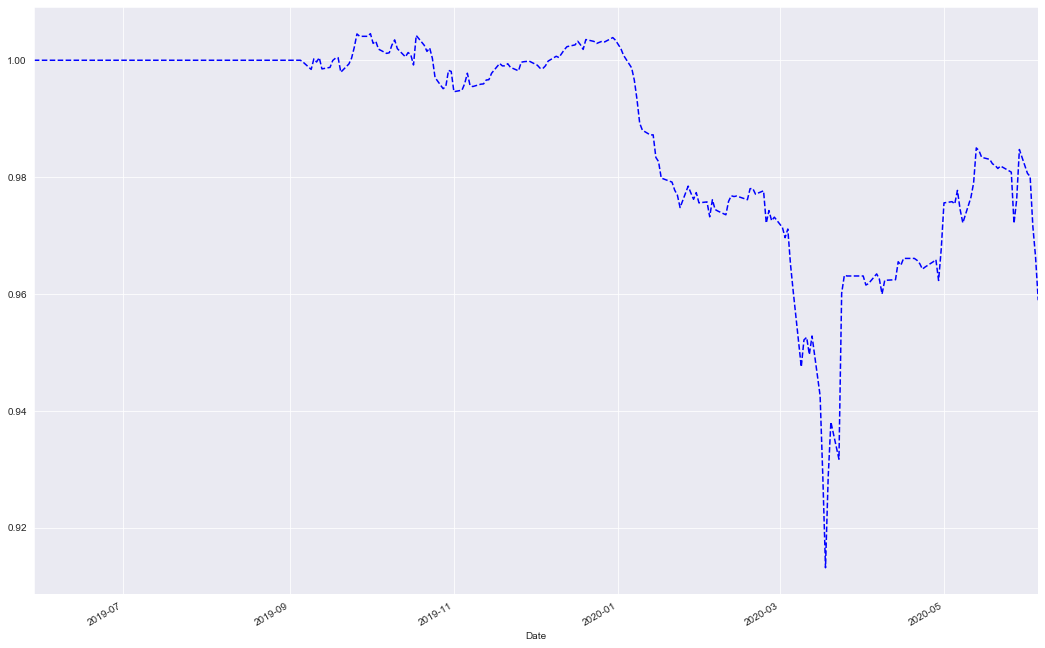

In [190]:
# PRINTS PORTFOLIO EQUITY CURVE
total_returns = 0
for equity_curve in all_cum_returns:
    total_returns += equity_curve 
total_returns = total_returns/len(all_cum_returns)
total_returns.plot(style = 'b--', figsize=(18,12))

total_returns_pct_chg = total_returns.pct_change()
total_returns_pct_chg

try:
    portfolio_sharpe_net = np.sqrt(252) * total_returns_pct_chg.mean() / total_returns_pct_chg.std()
except ZeroDivisionError:
    portfolio_sharpe_net = 0.0

end = total_returns.iloc[-1]
start = total_returns.iloc[0]
days = len(total_returns)
portfolio_cagr_net = ((end / start) ** (252/days))  - 1.0  

print(f'Portfolio of pairs performance:')
print(f'CAGR: {round(portfolio_cagr_net,4)}, Sharpe Ratio: {round(portfolio_sharpe_net,2)}')

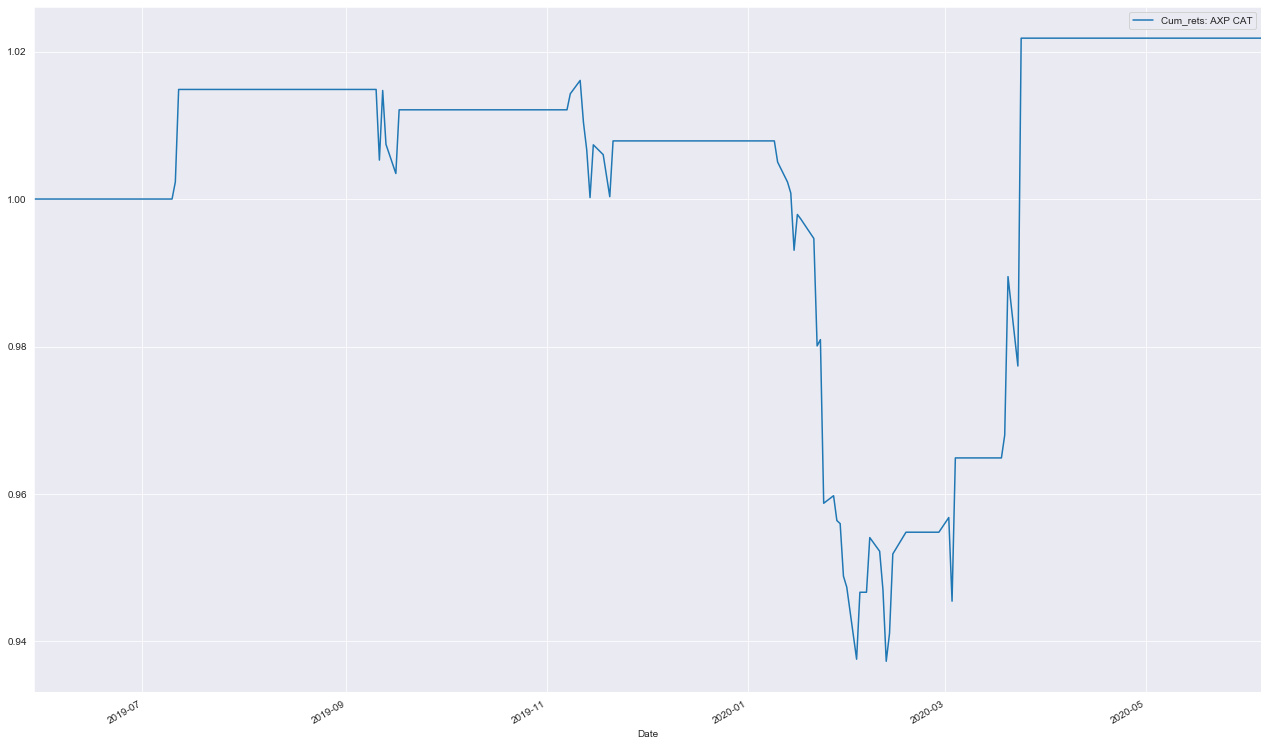

In [193]:
# HELPER SCRIPT: Backtesting a single pair from selected universe

cum_returns, CAGR, sharpe, num_days_in_market = backtest(df[train_sample:], 'AXP','CAT', strategy = 1, 
                                                             roll_beta_window = 10, zscore_window = 20,
# plots equity curve                                                             entryZscore = 2, exitZscore = 0.5)
# cum_returns.plot(figsize=(22,14),legend=True)

### Part 4: Checking current zScore of cointegrated pairs

In [178]:
def currentPortfolio(df, sym1, sym2, roll_beta_window = 5, zscore_window = 25 ):
    
    y = df[sym1].iloc[-(2*(roll_beta_window+zscore_window)):]
    x = df[sym2].iloc[-(2*(roll_beta_window+zscore_window)):]

    # Scrapes the current (real-time) price of the asset from yahoo.com
    def getCurrentPrice(sym):
        source = requests.get(f'https://finance.yahoo.com/quote/{sym}')   # https://finance.yahoo.com/quote/VTI?p=VTI
        soup = BeautifulSoup(source.content, 'lxml')
        price = soup.select_one('.Trsdu\(0\.3s\)').text
        price = price = float(price.replace(',', ""))
#       time.sleep(1)
        return(price)
    
    # modify ticker depending on the historcital data source
    if sym1[-3:] == '.US' or sym2[-3:] == '.US'  :
        sym1 = (sym1.split('.')[0])
        sym2 = (sym2.split('.')[0])
    
    # selects a small part of the existing dataframe needed to compute current zScore 
    s4 = pd.Series([getCurrentPrice(sym1)], index=[date.today()])
    s5 = pd.Series([getCurrentPrice(sym2)], index=[date.today()])
    
    # appends the current price to existing dataframe
    y = y.append(s4) 
    x = x.append(s5) 

    # finds intersection between two series and make sure DataFrames are the same length
    intersect = y.index.intersection(x.index)
    y = y.loc[intersect]
    x = x.loc[intersect]

    # creates a dataframe using adj. close prices from both series
    dataframe = pd.DataFrame(index=y.index).dropna()
    dataframe['%s_close' % sym1.lower()] = y
    dataframe['%s_close' % sym2.lower()] = x   
    
    # calculates rolling hedge ratio and spread and zScore
    roll_fit = RollingOLS(y, x, window=roll_beta_window).fit()
    dataframe['hr'] = -roll_fit.params
    dataframe['test_spread'] = y + (x * dataframe.hr)
    meanSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).mean()
    stdSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).std()
    dataframe['zScore'] = (dataframe['test_spread']- meanSpread) / stdSpread

    return dataframe['zScore'][-1], dataframe['hr'][-1] 

# ------------------------------------------------#

#CHECKS CURRENT ZSCORE for ALL cointegrated pairs
zscore_treshold = 2.0
zscores_list = []
print(f'Getting data for the pairs with current Z-score above {zscore_treshold}....\n')
for c, pair in enumerate(coint_pairs):
    print(f'{pair[0]}-{pair[1]}, zScore now is: {zscore_now})
    zscore_now, hedge_ratio_now = currentPortfolio(df[train_sample:], pair[0], pair[1], roll_beta_window = 5, zscore_window = 25)
    if abs(zscore_now) > abs(zscore_treshold):
        zscores_list.append((pair[0], pair[1], zscore_now, hedge_ratio_now))

if len(zscores_list) == 0:
    print('...')
    print(f'No pairs available to trade, i.e. no pairs with zscore > abs({zscore_treshold})')
else:    
    zscores_list_sorted = sorted(zscores_list, key=lambda x: abs(x[2]),reverse = True) 
    for c, pair in enumerate(zscores_list_sorted,1):
        if pair[2] < 0:
            print(f'{c}: Buy : 1.00 * |{pair[0]: <4}| Sell: {round(pair[3],5)}  * |{pair[1]: <4}| Z-Score: {round(pair[2],2)}')
        else:
            print(f'{c}: Sell: 1.00 * |{pair[0]: <4}| Buy:  {round(pair[3],5)}  * |{pair[1]: <4}| Z-Score:  {round(pair[2],2)}') 

Getting data for the pairs with current Z-score above 2.0....

AAPL CVX 1.0959511725457478
AAPL XOM -0.8249135288707231
AXP MCD -1.2834508023095663
AXP VZ -0.07598319325849207
AXP WMT 0.07923462014038221
CVX HD 0.5521949223451265
CVX JPM 1.118586488111924
HD JPM -0.6409133897999717
JNJ KO -1.0379638292971531
JNJ XOM -0.8586982574926266
MCD VZ -1.221595482780459
MCD WMT 0.2577712858688871
NKE VZ 1.0880404058485258
PFE VZ -0.9393203921783897
V VZ -0.5355005503270911
VZ WMT -0.5434515815805402
...
No pairs available to trade, i.e. no pairs with zscore > abs(2.0)


In [179]:
# HELPER SCRIPT: CHECKS CURRENT ZSCORE for selected pairs
pairs = [('EBAY', 'FB'), ('LRCX', 'MNST'), ('QCOM', 'SNPS'), ('COST', 'VRSK'), ('CSX', 'UAL'), ('ANSS', 'TXN')]
for pair in pairs:
    zscore_now, hedge_ratio_now = currentPortfolio(df[train_sample:], pair[0], pair[1], roll_beta_window = 5, zscore_window = 25 )
    print(f'{pair[0]}-{pair[1]}, zScore: {zscore_now}, hedge ratio: {hedge_ratio_now}' )

### Part 5: Parameters optimisation

In [185]:
# HELPER SCRIPT: Roll_beta_window optimisation

all_cagrs_and_sharpes = []
zscore_window = 20
entryZscore = 2.0
exitZscore = 0.5

# calculates portfolio Sharpe Ratio and CAGR  for each Roll_beta_window within the range
for x in range(10, 50, 5):
    all_cum_returns = []
    
    for pair in coint_pairs:
        cum_returns, CAGR, sharpe, num_days_in_the_market = backtest(df[train_sample:], pair[0],pair[1], strategy = 1, 
                                                                     roll_beta_window = x, zscore_window = zscore_window,
                                                                    entryZscore = entryZscore, exitZscore = exitZscore)
        all_cum_returns.append(cum_returns)
        
    total_returns = 0
    for equity_curve in all_cum_returns:
        total_returns += equity_curve 
    total_returns = total_returns/len(all_cum_returns)

    total_returns_pct_chg = total_returns.pct_change()

    try:
        portfolio_sharpe_net = np.sqrt(252) * total_returns_pct_chg.mean() / total_returns_pct_chg.std()
    except ZeroDivisionError:
        portfolio_sharpe_net = 0.0

    end = total_returns.iloc[-1]
    start = total_returns.iloc[0]
    days = len(total_returns)
    portfolio_cagr_net = ((end / start) ** (252/days))  - 1.0
    all_cagrs_and_sharpes.append((x, portfolio_cagr_net, portfolio_sharpe_net))
    
# sorts and prints ranked results based on Share Ratio
all_cagrs_and_sharpes = sorted(all_cagrs_and_sharpes, key=lambda x: x[2],reverse = True) 

for c, pair in enumerate(all_cagrs_and_sharpes, 1):
        print(f'{c}: Hedge ratio window: {pair[0]}, zScore window: {zscore_window}, CAGR: {round(pair[1],3)}, Sharpe Ratio: {round(pair[2],2)}')  

1: Hedge ratio window: 15, zScore window: 20, CAGR: 0.014, Sharpe Ratio: 0.28
2: Hedge ratio window: 20, zScore window: 20, CAGR: -0.004, Sharpe Ratio: -0.04
3: Hedge ratio window: 10, zScore window: 20, CAGR: -0.003, Sharpe Ratio: -0.08
4: Hedge ratio window: 35, zScore window: 20, CAGR: -0.026, Sharpe Ratio: -0.46
5: Hedge ratio window: 25, zScore window: 20, CAGR: -0.026, Sharpe Ratio: -0.47
6: Hedge ratio window: 40, zScore window: 20, CAGR: -0.028, Sharpe Ratio: -0.5
7: Hedge ratio window: 30, zScore window: 20, CAGR: -0.031, Sharpe Ratio: -0.57
8: Hedge ratio window: 45, zScore window: 20, CAGR: -0.04, Sharpe Ratio: -0.71


In [208]:
# HELPER SCRIPT: Z-score_window optimisation

all_cagrs_and_sharpes_zscore_optim = []
total_returns_all = []
roll_beta_window = 15
entryZscore = 2.0
exitZscore = 0.5

# calculates portfolio Sharpe Ratio and CAGR  for each zScore window within the range
for x in range(10, 50, 5):
    all_cum_returns = []
    
    for pair in coint_pairs:
        cum_returns, CAGR, sharpe, num_days_in_the_market = backtest(df[train_sample:], pair[0],pair[1], strategy = 1, 
                                                                     roll_beta_window = roll_beta_window, zscore_window = x,
                                                                    entryZscore = entryZscore, exitZscore = exitZscore)
        all_cum_returns.append(cum_returns)

    total_returns = 0
    for equity_curve in all_cum_returns:
        total_returns += equity_curve    
    total_returns = total_returns/len(all_cum_returns)
    total_returns_all.append((x, total_returns))
    total_returns_pct_chg = total_returns.pct_change()

    try:
        portfolio_sharpe_net = np.sqrt(252) * total_returns_pct_chg.mean() / total_returns_pct_chg.std()
    except ZeroDivisionError:
        portfolio_sharpe_net = 0.0

    end = total_returns.iloc[-1]
    start = total_returns.iloc[0]
    days = len(total_returns)
    portfolio_cagr_net = ((end / start) ** (252/days))  - 1.0
    all_cagrs_and_sharpes_zscore_optim.append((x, portfolio_cagr_net, portfolio_sharpe_net))

# sorts and prints ranked results based on Share Ratio
all_cagrs_and_sharpes_zscore_optim = sorted(all_cagrs_and_sharpes_zscore_optim, key=lambda x: x[2],reverse = True) 
for c, pair in enumerate(all_cagrs_and_sharpes_zscore_optim, 1):
        print(f'{c}: Hedge ratio window: {roll_beta_window}, zScore window: {pair[0]}, CAGR: {round(pair[1],3)}, Sharpe Ratio: {round(pair[2],2)}')  

1: Hedge ratio window: 15, zScore window: 10, CAGR: 0.03, Sharpe Ratio: 1.08
2: Hedge ratio window: 15, zScore window: 20, CAGR: 0.014, Sharpe Ratio: 0.28
3: Hedge ratio window: 15, zScore window: 15, CAGR: 0.003, Sharpe Ratio: 0.1
4: Hedge ratio window: 15, zScore window: 25, CAGR: -0.004, Sharpe Ratio: -0.06
5: Hedge ratio window: 15, zScore window: 30, CAGR: -0.008, Sharpe Ratio: -0.14
6: Hedge ratio window: 15, zScore window: 35, CAGR: -0.009, Sharpe Ratio: -0.16
7: Hedge ratio window: 15, zScore window: 45, CAGR: -0.018, Sharpe Ratio: -0.34
8: Hedge ratio window: 15, zScore window: 40, CAGR: -0.021, Sharpe Ratio: -0.39


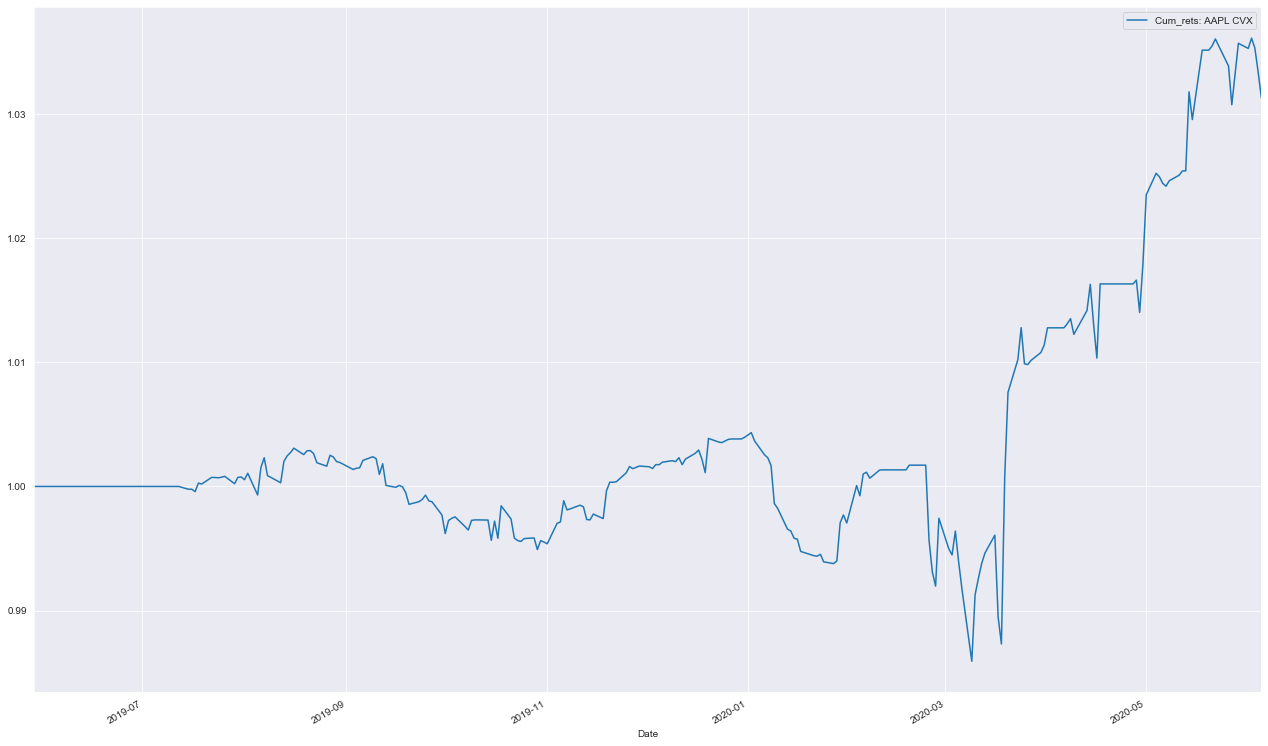

In [207]:
# PLOT EQUITY CURVE OF THE BEST MODEL : Hedge ratio window: 15, zScore window: 10, CAGR: 0.03, Sharpe Ratio: 1.08

# plots equity curve                                                             
total_returns_all[0][1].plot(figsize=(22,14),legend=True)

### CONCLUSION AND DISCLAIMER

This script presents fairly simple but complete and basic framework for Selection and Backtesting of a Portfolio of Pairs Based on Cointegration in Python.

The results probably do not encourage to use this model into live trading, however the purpose of creating this notebook is purely educational.

There are multiple ways how this basic framework may be extended into more unique and complex model.

If you have any questions, please send me email: p.arendarski...gmail.com...

DISCLAIMER:
This piece of code  is presented here is must be used solely for education perposes and can not be used under ciscumstances as a decision making tool in real trading.